# Module 1 - Lab assignment -  Using Mistral-7B for few-shot sentence classification.ipynb

This notebook presents an example of how to use Mistral-7B-Instruct model to perform few-shot sentence classification. Few-shot sentence classification is a type of text classification task in Natural Language Processing (NLP) that involves categorizing a piece of text, typically a sentence or a document, into predefined categories, such as positive, negative, or neutral, using only a few in-context examples.  In this example, we evaluate Mistral-7B-Instruct on the Stanford Sentiment Treebank (SST-2).

[Mistral](https://mistral.ai/news/announcing-mistral-7b/a) is a language model developed by Mistral AI, featuring 7.3 billion parameters. It is noted for its efficiency and effectiveness, outperforming larger models on various benchmarks and excelling in tasks involving both code and natural language. Mistral 7B utilizes an attention mechanisms that allows us to process long sequences. It is openly available under the Apache 2.0 license for unrestricted use.

* [Model](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1)
* [Dataset](https://huggingface.co/datasets/glue/viewer/sst2/test)

# Lab Assignment

For the lab assignment, search for **`TODO:`** in the cells and write your code to accomplish the task.

# Installing required packages

In this example, we have to install two libraries:  `transformers` and `datasets`, both from Hugging Face. [Hugging Face](https://huggingface.co/) is an AI startup that has gained significant traction in the NLP community recently. It provides a suite of open-source tools and libraries, making it easy for developers and researchers to work with state-of-the-art NLP models.

**`transformers`**:

Transformers is an open-source library for NLP developed by Hugging Face. It provides state-of-the-art pre-trained models for various NLP tasks, such as text classification, sentiment analysis, question-answering, named entity recognition, etc. The library is built on top of PyTorch and TensorFlow and provides easy-to-use interfaces to access pre-trained models and fine-tune them on specific tasks. The library also provides tools for training custom models and sharing them with the community.

**`datasets`**:

Datasets is another open-source library developed by Hugging Face that provides a collection of preprocessed datasets for various NLP tasks, such as sentiment analysis, natural language inference, machine translation, and many more. The library provides a unified API to access these datasets, making it easy to load, process, and analyze them.




In [ ]:
!pip install transformers
!pip install datasets

# Setting the device

In this example, we will use a GPU to speed up the processing of our model. GPUs (Graphics Processing Units) are specialized processors that are optimized for performing large-scale computations in parallel. By using a GPU, we can accelerate the training and inference of a machine learning model, which can significantly reduce the time required to complete these tasks.

Before we begin, we need to check whether a GPU is available and select it as the default device for our PyTorch operations. This is because PyTorch can use either a CPU or a GPU to perform computations, and by default, it will use the CPU.

For using a GPU in Google Colab:
1. Click on the "Runtime" menu at the top of the screen.
2. From the dropdown menu, click on "Change runtime type".
3. In the popup window that appears, select "GPU" as the hardware accelerator.
4. Click on the "Save" button.

That's it! Now you can use the GPU for faster computations in your notebook.

In [ ]:
!nvidia-smi

In [ ]:
import torch
device="cuda"

torch.set_default_device(device)

# Downloading the model

We use the **`transformers`** library to load the pre-trained Mistral-7B-Instruct model. The library provides a unified API to access various pre-trained models, including Mistral-7B-Instruct. It also provides tools to fine-tune these models on specific tasks, such as text classification, question-answering, etc.

We use the **`from_pretrained`** method to load the pre-trained model. The method takes the name of the model as an argument and returns a PyTorch model object. The name of the model is the name of the repository on the Hugging Face model hub. For example, the name of the Mistral-7B-Instruct model is **`mistralai/Mistral-7B-Instruct-v0.1`**.

The **`from_pretrained`** method also takes an optional **`torch_dtype`** argument, which specifies the data type of the model parameters. By default, the model parameters are stored in the **`float32`** data type, which is the standard data type for most deep learning models. However, we can also store the model parameters in the **`float16`** data type, which is a lower-precision data type that can reduce the memory requirements of the model. This can be useful when we are working with large models that do not fit in the memory of our GPU.

In this example, we will set the **`torch_dtype`** argument to **`"auto"`**, which will automatically select the data type based on the hardware we are using. If we are using a GPU, the model parameters will be stored in the **`float16`** data type, and if we are using a CPU, the model parameters will be stored in the **`float32`** data type.

We use the **`to`** method to move the model to the default device. This will ensure that the model parameters are stored in the memory of the GPU, if available, or the CPU, if a GPU is not available.

In [ ]:
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM


model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1",
                                             torch_dtype="auto")

model.to(device)

We also load the tokenizer for the model using the **`AutoTokenizer.from_pretrained`** method. The tokenizer is used to convert a piece of text into a sequence of tokens, which can then be fed into the model.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1",
                                          torch_dtype="auto")

# Downloading Dataset

The SST-2 dataset, or the Stanford Sentiment Treebank, is popular for sentiment analysis tasks in Natural Language Processing (NLP). It consists of movie reviews from the Rotten Tomatoes website that are labeled with either a positive or negative sentiment. The dataset contains 10,662 sentence-level movie reviews, with approximately half of the reviews labeled as positive and the other half labeled as negative. The reviews are also relatively evenly distributed in length, with a median length of 18 tokens.

The SST-2 dataset has become a benchmark dataset for sentiment analysis in NLP, and many researchers use it to evaluate the performance of their models. The dataset's popularity is partly due to its high-quality labels and the task's relative simplicity, making it an accessible starting point for researchers and developers new to NLP.

In this example, we're using the **`datasets`** library to download and load the validation and training sets of the dataset.

In [ ]:
from datasets import load_dataset

test_dataset = load_dataset('glue', 'sst2', split='validation')
train_dataset = load_dataset('glue', 'sst2', split='train')

The code below converts the `label` column of the dataset into a list of strings with `"positive"` and `"negative"` labels. This is for comparing the model's predictions with the actual labels of the dataset.

In [ ]:
POSITIVE_LABEL = "positive"
NEGATIVE_LABEL = "negative"

test_dataset = test_dataset.map(lambda example: {'label_name': POSITIVE_LABEL if example["label"] == 1 else NEGATIVE_LABEL})
train_dataset = test_dataset.map(lambda example: {'label_name': POSITIVE_LABEL if example["label"] == 1 else NEGATIVE_LABEL})

In this code, we use the **`pandas`** library to import the SST-2 dataset and show the first 10 examples using the **`df.head(10)`** method. The dataset contains examples labeled as either 0 or 1, representing negative and positive, respectively. For instance, the first example is labeled as 1, which means it is a positive example. It reads "it's a charming and often affecting journey," while the second example is labeled as 0, meaning it is a negative example. It reads "unflinchingly bleak and desperate."
This way, you can have a quick overview of the dataset and its labeling.

In [ ]:
import pandas as pd

df = pd.DataFrame(test_dataset)
df.head(10)

# Prompt Engineering with Mistral-7B-Instruct

Prompt engineering is a technique that involves providing the model with a prompt, which is a piece of text that instructs the model to perform a specific task. The model then generates the desired output based on the prompt. Prompting Mistral-7B-Instruct is quite different from prompting OpenAI's models. Mistral-7B-Instruct was finetuned on instruction datasets publicly available.

It's recommended to use the following chat template when using Mistral 7B Instruct:

```
<s>[INST] Instruction [/INST] Model answer</s>[INST] Follow-up instruction [/INST]
```

Note that `<s>` and `</s>` are special tokens for beginning of string (BOS) and end of string (EOS) while `[INST]` and `[/INST]` are regular strings that mark the beginning and end of the instruction. Consider the following example:

Prompt:

```
[INST] You are a helpful code assistant. Your task is to generate a valid JSON object based on the given information:

name: John
lastname: Smith
address: #1 Samuel St.

Just generate the JSON object without explanations:
[/INST]
```

Output:

```
{
  "name": "John",
  "lastname": "Smith",
  "address": "#1 Samuel St."
}
```

For few-shot prompt engineering, we can use the following template:

```
<s>[INST] You are a helpful code assistant. Your task is to generate a valid JSON object based on the given information. So for instance the following:

name: John
lastname: Smith
address: #1 Samuel St.

would be converted to:[/INST]
{
"address": "#1 Samuel St.",
"lastname": "Smith",
"name": "John"
}
</s>
[INST]
name: Ted
lastname: Pot
address: #1 Bisson St.
[/INST]
```

### **Important**:

* the **`</s>`** token after the first output, which is used to mark the end of the first output. It also serves as stop token for the model. The model will generate the second output until it generates the **`</s>`** token.

* the inputs are separated by the **`[INST]`** and **`[/INST]`** tokens. The model will generate the first output based on the first input, and the second output based on the second input.

See the [Prompt Engineering Guide](https://www.promptingguide.ai/models/mistral-7b) model card for more details.

In this example, we use the following instruction:

```
[INST] You are a sentiment classifier. Use only "positive." or "negative".
```

Notice that we omit the `[\INST]` token, as it must be added after the the target documents and question.

In [ ]:
instruction = """You are a sentiment classifier. Use only "positive." or "negative".
"""

Now, we define the input and output templates to structure the interaction with the model for sentence classification.

In [ ]:
"""
TODO: create the input and the output tamplates.
* The input must contain the target sentence;
* The output must contain the classification

** Remember of using the special tokens <s>, </s> and the markers [INST] [/INST].
"""

input_template = """YOUR TEMPLATE HERE"""
output_template = """YOUR TEMPLATE HERE"""


# Inference

The code below defines a function named `generate` that is used to generate text output from Mistral-7B. The function takes a string input, `text`, and processes it using a pre-trained model and tokenizer. Here's a breakdown of its key components:

1. **Function Definition**:
   - `def generate(text)`: Defines the function `generate` with a single parameter, `text`, which is the input text for generation.

2. **Tokenization**:
   - The input text is tokenized using a tokenizer. `return_tensors="pt"` indicates that the output will be PyTorch tensors. `add_special_tokens=False` suggests that special tokens for sequence start or end are not automatically added to the input.

3. **Model Inputs**:
   - The tokenized input is moved to a specified device (like GPU or CPU), making it ready for the model to process.

4. **Generating Output**:
   - The `with torch.no_grad():` block ensures that no gradients are calculated during the forward pass, reducing memory usage and speeding up computation.
   -  Then,  the function generates the output using the model.

5. **Decoding and Returning the Output**:
   - The function decodes the generated token IDs back into a string. It skips the part of the output that corresponds to the input tokens and also skips any special tokens in the decoding process. This ensures that the returned text is clean and readable, containing only the generated content without any formatting tokens.


In [ ]:
def generate(text: str) -> str:
  """
  TODO: implement the function that performs the inference and returns the output
  This function receives a text as input and must return a text
  """

  # The three main parts of this function are:

  # 1. encode the input text

  # 2. generate the output

  # 3. decode and return the outputs

The code below defines a function `classify_sentence` for classifying a given sentence into a specific category, using a k-shot learning approach. The function takes two arguments: `sentence`, the sentence to be classified, and `k_shot`, the number of examples to use for few-shot learning. Here’s a step-by-step breakdown:

1. **Importing the Random Library**:
   - `import random`: This imports the Python `random` module, which provides functions for generating random numbers, a functionality used later in the code.

2. **Function Definition**:
   - `def classify_sentence(sentence, k_shot)`: Defines the function with `sentence` (the text to be classified) and `k_shot` (the number of training examples to use) as parameters.

3. **Creating the Prompt for the Language Model**:
   - `prompt = instruction`: Initializes the prompt with a predefined instruction. This `instruction` is not shown in the snippet but is assumed to be a string that sets the context for the classification task.
   - `idxs = random.sample(list(range(len(train_dataset))), k_shot)`: Selects `k_shot` random indices from the training dataset.
   - The loop `for ex in train_dataset.select(idxs)`: Iterates over the randomly selected examples from the training dataset. For each example:
     - `prompt += input_template.format(sentence=ex['sentence'])`: Formats and adds the sentence from the example to the prompt.
     - `prompt += output_template.format(label=ex["label_name"])`: Formats and adds the corresponding label from the example to the prompt.

4. **Adding the Target Sentence to the Prompt**:
   - `prompt += input_template.format(sentence=sentence)`: Adds the target sentence (the one to be classified) to the prompt in the same format as the few-shot examples.

5. **Generating the Classification Result**:
   - `res = generate(prompt)`: Calls the `generate` function, which is presumably a language model, to process the prompt and generate a classification result.

6. **Extracting and Returning the Classification**:
   - `return res.split(":")[-1].strip()`: Splits the result by “:” and returns the last element, which is expected to be the classification label, stripped of any leading or trailing whitespace.

7. **Classifying a Sample Sentence**:
   - `res = classify_sentence("This movie is too good", 3)`: Calls the `classify_sentence` function with a sample sentence and 3 as the number of few-shot examples.
   - `print(res)`: Prints the classification result for the sample sentence.

In [ ]:
import random

def classify_sentence(sentence,k_shot):
  prompt = instruction
  idxs = random.sample(list(range(len(train_dataset))), k_shot)
  for ex in train_dataset.select(idxs):
    prompt += input_template.format(sentence=ex['sentence'])
    prompt += output_template.format(label=ex["label_name"])
  prompt += input_template.format(sentence=sentence)

  res = generate(prompt)

  return res.split(":")[-1].strip() # This splits "Class: negative|positive". You can also use JSON.

res = classify_sentence("This movie is too good", 3)
print(res)

The code below uses the **`classify_sentence`** function to make predictions on the test dataset. We loop through the test dataset and apply the **`classify_sentence`** function to each example. The predictions are stored in a list called **`predictions`**.

In [ ]:
from tqdm import tqdm

k_shot = "3" # @param [1,2,3,4,5,10,20]

predictions = []
references = test_dataset["label_name"]
for item in tqdm(test_dataset):
  predicted = classify_sentence(item['sentence'], int(k_shot))
  predictions.append(predicted)


# Evaluation Metric

To compute accuracy, we need to define a custom **`string_accuracy`** function since the model outputs text rather than numerical values. Therefore, we cannot use the built-in accuracy function directly, which expects numerical values as inputs.

The following code defines the **`string_accuracy`** function. It takes two lists of strings as inputs, **`predictions`** and **`references`**. The function computes accuracy by counting the number of predictions that match the corresponding reference and dividing by the total number of predictions.

In [ ]:
def string_accuracy(predictions, references):
    correct = sum([1 for p, r in zip(predictions, references) if p.lower() == r.lower()])
    total = len(predictions)
    return correct / total

# Evaluation

We can compute the accuracy of our approach using the **`string_accuracy`** function defined earlier. The function takes two lists of strings as inputs, **`predictions`** and **`references`**. The function computes accuracy by counting the number of predictions that match the corresponding reference and dividing by the total number of predictions.

In [ ]:
from collections import Counter
c = Counter(predictions)
c.most_common()

[('negative', 448), ('positive', 392), ('neutral', 31), ('mixed', 1)]

The model can generate texts others than "positive" and "negative". This way, we need to post-process the output.



In [ ]:
predictions = [p.lower() for p in predictions]
predictions = ["negative" if p != "positive" else p for p in predictions]

Then, we can calculate the accuracy.

In [ ]:
accuracy = string_accuracy(predictions=predictions, references=references)
accuracy

0.9128440366972477

We also can plot a confusion matrix to see how the model performed on each class. Let's compute the confusion matrix using the **`confusion_matrix`** function from the **`sklearn.metrics`** library. The function takes two lists of strings as inputs, **`predictions`** and **`references`**. The function computes the confusion matrix by counting the number of predictions that match the corresponding reference and dividing by the total number of predictions. Then, we use the **`heatmap`** function from the **`seaborn`** library to plot the confusion matrix.

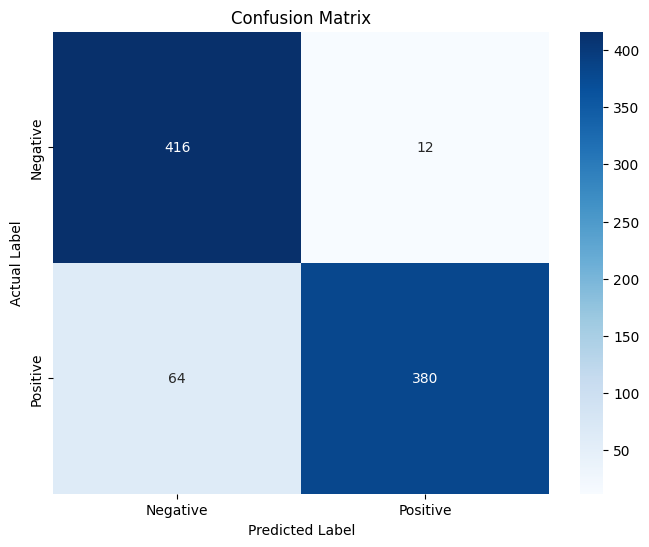

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Convert labels to a numerical form
labels = {"positive": 1, "negative": 0}
y_true_num = [labels[label] for label in references]
y_pred_num = [labels[label] for label in predictions]

# Compute the confusion matrix
cm = confusion_matrix(y_true_num, y_pred_num)

# Plot the confusion matrix using seaborn
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])

# Labels, title, and ticks
ax.set_ylabel('Actual Label')
ax.set_xlabel('Predicted Label')
ax.set_title('Confusion Matrix')

# Show the plot
plt.show()


# Try it yourself

You can try sentiment analysis with your own sentences by providing the input text as a string to the **`text`** variable in the code snippet provided below.

The code defines a function **`classify_sentence`** that takes a string **`text`** as input. The **`text`** variable should be provided with a sentence or a text fragment for which sentiment analysis needs to be performed.

In [ ]:
k_shot = "10" # @param [1,2,3,4,5,10,20]
text = "This movie is awesome!" # @param
class_label = classify_sentence(text,int(k_shot))
print(f"The sentence '{text}' is classified as '{class_label}'.")

The sentence 'This movie is awesome!' is classified as 'positive'.
